***

# Project 3 - Monte Carlo Methods

***

Leonie English 

University of Manchester

April - May 2024

***

Initialising Python interpreter:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import constants
import time as timer

notebook_runtime_start = timer.time()

plt.rcParams.update({'font.size' : 12})
plt.style.use('default')

## Introduction to the project

This project will aim to evaluate the rate of each process involved in thermalised neutrons that interact with a shielding layer. These processes include neutrons being absorbed by the shield, backscattering, and neutrons passing through the shielding. All of these processes are a function of the thickness of the shield, and this will be different for the material that the shield is made out of. Three materials will be investigated - water, lead, and graphite. In the real world, most neutron shielding mechanisms are made from multiple materials, usually taking advantage of high absorption cross-sections.

Neutrons mainly interact with the nucleus of any shielding material, and not electrons, as they do not have a charge. When a neutron interacts with matter, it may release a gamma ray, or some other type of energy, dependent on its incident energy and the material which it is interacting with. Thermalised neutrons have an energy of ~0.025eV, which is quite low compared to the range of energies which they may have in a nuclear reactor.

Some constants that correspond to each of the three materials are imported as global variables, they are listed in the table below.

|Parameter| Water | Lead | Graphite |
|:--------:|:--------:|:--------:|:--------:|
|Absorption, $\sigma_a$ (barn)|  0.6652   |  0.158   |  0.0045   |
|Scattering, $\sigma_s$ (barn)|  103.0   |  11.221   |  4.74   |
|Density, $\rho$ (g/cm${}^3$)|  1.00   |  11.35   |  1.67   |
|Molar mass, $M$, (g/mol)|    18.0153      |  207.2        |    12.011      |

In [2]:
# Absorption cross-section global array, barns
ABSORPTION = np.array([0.6652, 0.158, 0.0045])

# Scattering cross-section global array, barns
SCATTERING = np.array([103.0, 11.221, 4.74])

# Density global array, g/cm^3
DENSITY = np.array([1.00, 11.35, 1.67])

# Molar mass global array, g/mol
MOLAR_MASS = np.array([18.0153, 207.2, 12.011])

## Introduction to the Monte Carlo method

### The Monte Carlo Integration Method

The Monte Carlo method uses randomness to determine orders and patterns in chaotic systems, where it performs a statistical determination of a range of possible outcomes and the probability rates by which they might occur for any action.

Integration over a particular integral can be written as

$$
I = \int_{x_1}^{x_2}\,f(x)\,dx\,=\,(x_2 - x_1)\,\left<f(x)\right>,
$$

where $\left<f(x)\right>$ is the averge value of the function, and $x_1$, $x_2$, are the upper and lower bounds of the integral. This can also be written as an algorithm, 

$$
I \approx I_N = \left(x_2 - x_1\right)\frac{1}{N}\Sigma_{i=1}^N f_i,
$$

where $N$ corresponds to each sample taken, with each sample taken being a random number.

### Random number generator in 1D

The first thing to determine when using the Monte Carlo method is how random the random number generator used actually is. No random number generator is truly random, but uniformity, and no bias towards a certain section of the number scale is ideal. In actuality, a random number generator used for the Monte Carlo method is usually psuedo-random. What is actually wanted is a sequence of numbers which have no correlation to the process that is being considered.

The randomness of the number generator will be determined quantitatively through plotting a histogram of the frequency of certain numbers produced by different random number generators available to use during this project.

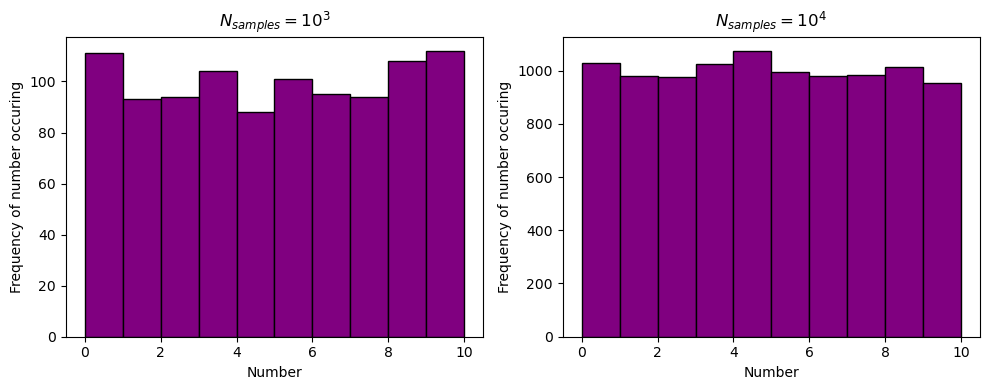

In [3]:
def random_number_fn(lower_limit, upper_limit, number_samples, dimensions):
    """
    Generates an array of random numbers that are uniform within the specified region. 
    
    Parameters: 
        lower_limit (float, float-like np.ndarray): The lower limit of the distribution
        upper_limit (float, float-like np.ndarray): The upper limit of the distribution
        number_sample (int): The number of random number samples
        dimensions (int): The number of dimensions that the random number samples are taken over
    
    Returns:
        random_number_output (np.ndarray, float): An N-dimensional array of random numbers.
    """
    random_number_output = np.random.uniform(lower_limit, upper_limit, size=(number_samples, dimensions))
    return random_number_output

# Take different numbers of samples over the same range of numbers
number_samples_array = [1000, 10000]
lower_limit_1d = 0
upper_limit_1d= 10

one_dimension_array = []
for number in number_samples_array:
    one_dimension_rand = np.ndarray.flatten(random_number_fn(lower_limit_1d, upper_limit_1d, number, 1))
    one_dimension_array.append([one_dimension_rand]) 

# Plotting these results in a histogram
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(one_dimension_array[0][0], bins=range(11), edgecolor='black', color='purple')
axs[1].hist(one_dimension_array[1][0], bins=range(11), edgecolor='black', color='purple')

axs[0].set_xlabel('Number')
axs[0].set_ylabel('Frequency of number occuring')
axs[0].set_title('$N_{samples} = 10^3$')

axs[1].set_xlabel('Number')
axs[1].set_ylabel('Frequency of number occuring')
axs[1].set_title('$N_{samples} = 10^4$')

plt.tight_layout()
plt.show()

There is no obvious bias towards any number, and as the number of samples increases, the distribution gets closer to being completely uniform. Quantifying this even further, the approach towards uniformity can be better expressed by repeating the calculation for $N_{samples}=100$ many times. A higher $N_{samples}$ is not used to save computation time. This has then been plotted as a histogram, with each iteration overlayed over each other. When the graph is opaque, this corresponds to the most likely outcome.

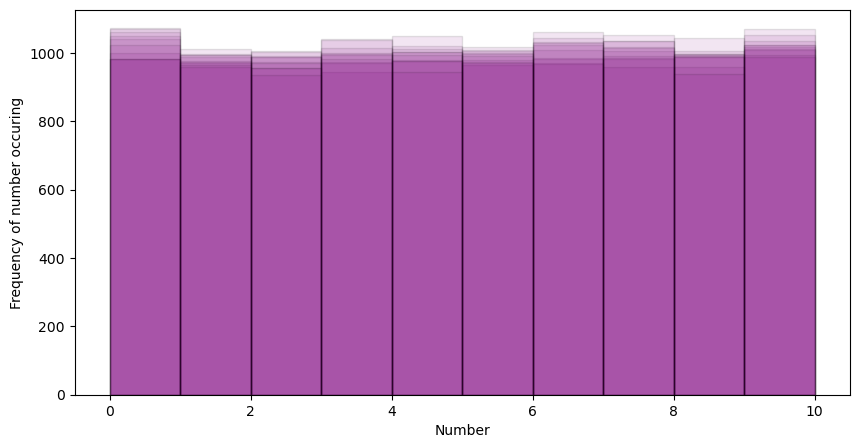

In [4]:
n_iterations = 10
number_samples = 100

one_dimension_array = []
for iteration in range(n_iterations):
    one_dimension_rand = np.ndarray.flatten(random_number_fn(lower_limit_1d, upper_limit_1d, number, 1))
    one_dimension_array.append([one_dimension_rand])

fig, axs = plt.subplots(figsize=(10, 5))
for array, i in enumerate(one_dimension_array):
    axs.hist(one_dimension_array[array][0], alpha=0.1, color='purple', bins=range(11), edgecolor='black')
    
axs.set_xlabel('Number')
axs.set_ylabel('Frequency of number occuring')
plt.show()

The density of the histogram bins is uniform, with some random deviation shown at the top. This confirms the notion that the number generator is in fact uniformly random. 

### Random number generation extended to 3 dimensions

The function written for the random number generator is already set up for three dimensions. To confirm there are no spectral issues, this will be plotted in an interactive 3D scatter plot.

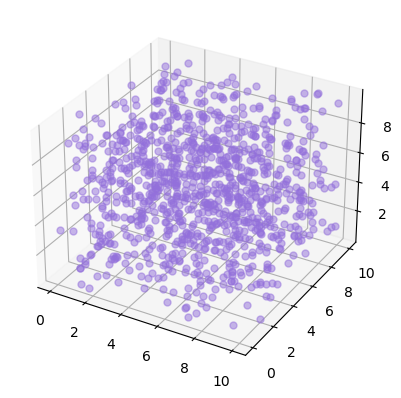

In [5]:
lower_limit_3d = [0, 0, 0]
upper_limit_3d = [10, 10, 10]

number_samples = 1000
three_dimension_rand = random_number_fn(lower_limit_3d, upper_limit_3d, number_samples, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(three_dimension_rand[:,0], three_dimension_rand[:,1], three_dimension_rand[:,2], marker='o',
        linestyle='None', markersize = 5.0, c='mediumpurple', alpha=0.5)

plt.show()

It is clear to see that the points are evenly distributed across the cube, and to confirm this further, the histogram of the points is plotted as well. There are no spectral issues with this random number generator.

There exists a few types of random number generators. In the case of **"np.random.uniform()"**, the random numbers are drawn from a uniform probability distribution, according to  

$$
p\,(x)=\frac{1}{b-a},
$$

where $b$ is the high limit, and $a$ is the lower limit, with $p\,(x)$ describing its probability distribution. It is the same everywhere, except when it is zero outside the range of $a\leq x\leq b$. This means that the numbers are psuedo-random, as the function displays statistical randomness, and not true randomness. The function also chooses a random seed if no seed is previously defined. In fact, all numbers generated by a computer are never truly random - every number is generated following logical steps.

The seed of a pseudo-random number generator is the "starting number" - the generation of psuedo-random numbers is deterministic, meaning that given one number in the sequence, the rest can be reproduced. The seed determines the entire following sequence of numbers, therefore presetting this can ensure that whatever sequence of random numbers is obtained will always be the same.

### The RANDSSP Multiplicative Congruential uniform random number generator

An example of a pseudo-random number generator with spectral issues is the RANDSSP Multiplicative Congruential uniform random number generator - this will be shortened to RANDSSP. Any multiplicative pseudo-random number generator works through taking a starting number, a seed, $X_0$, which is then multiplied by a factor $k$, and an offset/increment, $c$, may or may not be added. The modulus, $m$, is then taken of the product. This forms an equation which can be incremented over many times, 

$$
\begin{align}
X_{n+1}=kX_n+c\,, && \textit{mod}\,\,\, m
\end{align}
$$

$$
\\ 0 \leq X_0 < m\,,
\\ 0 < m\,,
\\ 0 \leq k < m\,,
\\ 0 < c < m.
$$

The results of the RANDSSP pseudo-random number generator in 3D are coded below.

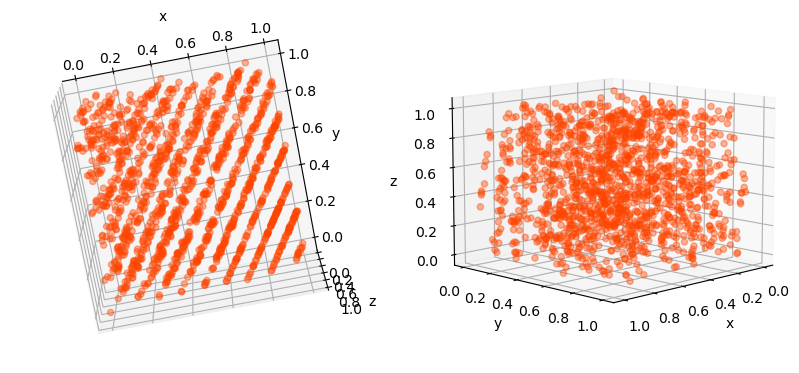

In [6]:
def randssp(dim1, dim2):
    """
    Finds psuedo-random numbers with an output corresponding to a [dim1 x dim2] matrix of pseudo-random numbers. The
    function cannot accept any starting seed other than 123456789. The inputs dim1 and dim2 are automatically set to 1 if
    they are not defined. The seed is also set to a certain value if undefined. For each element in the matrix, the seed is
    updated using the formula np.mod(multiplier*seed + increment, modulus). The function then assigns the normalised value,
    seed/modulus, to each element in the matrix.
    """
    
    global modulus, multiplier, increment, seed
        
    try: seed
    except NameError:
        modulus = pow(2, 31)
        multiplier = pow(2, 16) + 3
        increment = 0
        seed = 123456789
    
    try: dim1
    except NameError:
        dim1 = 1
    try: dim1
    except NameError:
        dim2 = dim
    
    random_matrix = np.zeros([dim1,dim2])

    for l in range (0, dim2):
        for k in range (0, dim1):
            seed = np.mod(multiplier*seed + increment, modulus)
            random_matrix[k, l] = seed/modulus
    
    return random_matrix

random_numbers = randssp(3, 1500)

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121, projection='3d')  
ax2 = fig.add_subplot(122, projection='3d')  

ax1.scatter(random_numbers[0, :], random_numbers[1, :], random_numbers[2, :], c='orangered', alpha=0.4)
ax2.scatter(random_numbers[0, :], random_numbers[1, :], random_numbers[2, :], c='orangered', alpha=0.4)

for ax in [ax1, ax2]:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# Set view for each subplot
ax1.view_init(elev=101, azim=-101)
ax2.view_init(elev=10, azim=45)

plt.show()

From the above plots, it can be seen that there are period planes, visible in the z-plane. The period planes themselves lie on the X-Z or Y-Z plane, they are rotated 45 degrees from either of these planes. These planes are called hyperplanes and are 2 dimensional. The occurence of hyperplanes means there is a correlation between these points, and that this random number generator fails a spectral test. 

This phenomenon is explained by Marsalgia's theorem, which states that: "There are at most $|c_1| + |c_2| + ... + |c_n|$ hyperplanes which intersect the unit $n$-cube, and there is always a choice of $\Sigma^n_i=c_i$ such that all of the points fall in fewer than $(n!m)^{1/n}$ hyperplanes." The original paper can be found at [this link](https://www.pnas.org/doi/pdf/10.1073/pnas.61.1.25), and this statement is directly quoted from it. Since parallel planes are produced periodically from these random number generators, they are not a good choice for a Monte Carlo simulation.

## Random number generator - Exponential distribution

Forming a random number generator that draws numbers from an exponential distrubtion involves taking the probability density function, PDF, and forming the inverse cumulative distribution function, inverse CDF. The CDF is formed through integrating the PDF from $-\infty$ to $x$. For the exponential distribution,

$$
P(x) = exp\left(-\frac{x}{\lambda}\right),
$$

where $x$ is a point on the PDF, and $\lambda$ is the mean free path. The CDF is therefore

$$
\begin{align}
C(x) &&=&& \int^x_{0}exp\left(-x\right) dx && = && 1 - exp\left(-x\right),
\end{align}
$$

which makes the inverse CDF, including the mean free path,

$$
\left[C(x)\right]^{-1} = -\lambda\,ln\left(1-x\right).
$$

The uniform random number generator is mulitplied by the inverse CDF and this should form a random number distribution drawn from the exponential distribution. 

In [7]:
def exp_random_number_fn(lower_limit, upper_limit, number_samples, dimensions, meanfreepath):
    """
    Parameters: 
        lower_limit (float, float-like np.ndarray): The lower limit of the distribution
        upper_limit (float, float-like np.ndarray): The upper limit of the distribution
        number_sample (int): The number of random number samples
        dimensions (int): The number of dimensions that the random number samples are taken over
        meanfreepath (float): The physical parameter corresponding to the mean free path of a certain particle, m
    
    Returns:
        random_number_output (np.ndarray, float): An N-dimensional array of random numbers.
    """
    uniform_random_number = random_number_fn(lower_limit, upper_limit, number_samples, dimensions)
    inverse_cdf = -(meanfreepath)*np.log(uniform_random_number)
    exp_random_number_output = inverse_cdf 
    
    return exp_random_number_output

### Application to neutrons in water

The mean free path of neutrons in water is then used to demonstrate that this works, through calculating the attenuation length of neutrons in water. The attenuation length is defined as the thickness when the intensity of the neutrons incident on the material drops to $1/e$. The system is modelled using the following equations, which are formed through considering a finite number of molecules that can absorb neutrons, 

$$
\begin{align}
n = \frac{\rho N_A}{M}, && \Sigma = n\sigma, && \lambda = \frac{1}{\Sigma},
\end{align}
$$

where $n$ is the number of absorbing molecules, $\rho$ is the density, $M$ is the molar mass, $N_A$ is Avogadro's number, $\Sigma$ is the macroscopic cross-section, and $\sigma$ is the microscopic cross-section. The absorption is the only process currently being considered, with scattering and transmission ignored.

In [8]:
def mean_free_path_calc(density, molar_mass, micro_cross_section):
    """
    Calculates the mean free path, the average time a neutron takes before a collision, given the cross section of
    absorption, density of the material, and molar mass of the material.
    
    Parameters:
        density (float):
        molar_mass (float):
        micro_cross_section (float): 
    
    Returns:
        mean_free_path (float): Mean free path of neutrons in a certain material, m
    """
    number_absorbing_molecules = (density*10**6*constants.Avogadro)/(molar_mass)
    macro_cross_section = number_absorbing_molecules * (micro_cross_section * 10**-28)
    mean_free_path = 1 / macro_cross_section
    return mean_free_path

The rate of absorption per unit thickness, $R$, is defined as

$$
R \,\,=\,\, -\frac{dI}{dx}\,\,=\,\, n\sigma IL,
$$

where $I$ is the intensity of neutrons incident on the material, $x$ is the "unit thickness" of the material, and $L$ is the thickness of the material. The solution to this differential equation is an exponential function, meaning the exponential random number generator can be used to model the behaviour of this equation. 

The code for the random number generator is just one iteration of the generation of an exponential distribution. To obtain a more accurate distribution, it will be iterated over many times, and a histogram plotted for a fixed number of particles with an exponential distribution. A weighted fit will then be performed using np.polyfit, with the weighting being the error on each bin of the histogram, which is the standard deviation divided by the mean. The error on the fit will be one over this error.

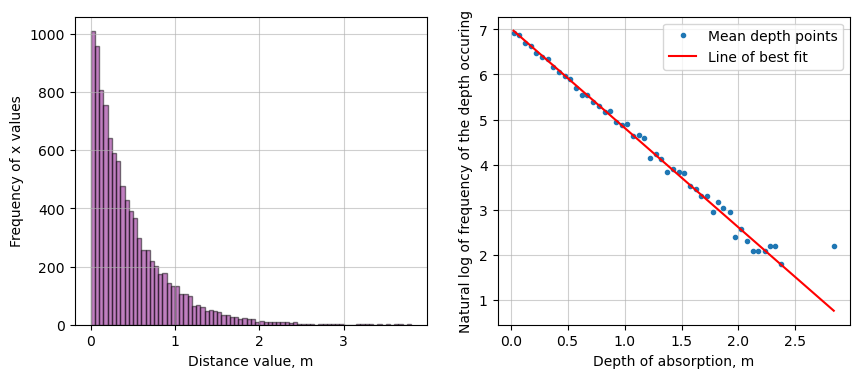

The mean free path is calculated to be 0.454 +/- 0.011 m.


In [9]:
def random_number_iteration_fn(lower_limit, upper_limit, number_samples, number_iterations, dimensions, meanfreepath):
    """
    Iterates over the exponential random number generator, exp_random_number_fn(), and plots a histogram that displays the
    probability of a neutron being absorbed at different values of thickness, x. Calculates the error on each bin of the
    histogram. The attenuation length is when the intensity drops to 1/e of its original value. 
    
    Parameters:
        lower_limit (float, float-like np.ndarray): The lower limit of the distribution
        upper_limit (float, float-like np.ndarray): The upper limit of the distribution
        number_sample (int): The number of random number samples
        dimensions (int): The number of dimensions that the random number samples are taken over
        meanfreepath (float): The physical parameter corresponding to the mean free path of a certain particle, m
    
    Returns:
        random_iterations (np.ndarray, float): A number_samples*number_iterations size 1D array of random numbers
    """
    # Preallocate memory
    random_iterations_new = np.empty(number_samples * number_iterations)
    
    # Iterates over the random number generator
    random_iterations_new = np.array([exp_random_number_fn(lower_limit, upper_limit, number_samples,
                                                           dimensions, meanfreepath)
                                      for _ in range(number_iterations)]).flatten()
    return random_iterations_new


def polyfit_fn(x, y, n, error_hist):
    """
    Performs a least squares polynomial fit. The covariance matrix being set to True means that the variance of
    the gradient and y-intercept are calculated for our data to the fit, and the standard deviation can be obtained through
    taking the square root of this, therefore giving errors on the gradient and y-intercept.
    
    Parameters:
        x (np.ndarry, floats): Values on x-axis
        y (np.ndarry, floats): Array, floats, values on y-axis
        n (int): Degree of polynomial fit
        
    Returns:
        fit_m (float): Gradient calculated from np.polyfit
        fit_c (float): Y-intercept calculated from np.polyfit
        error_m (float): Error on gradient calculated from np.polyfit
        error_c (float): Error on y-intercept calculated from np.polyfit
    """
    weighting = 1 / error_hist
    fit_parameters, fit_errors = np.polyfit(x, y, n, w=weighting, cov=True)
    fit_m = fit_parameters[0]
    fit_c = fit_parameters[1]
    
    error_m = np.sqrt(fit_errors[0][0])
    error_c = np.sqrt(fit_errors[1][1])
    
    return fit_m, fit_c, error_m, error_c


def histogram_function(data):
    """
    Plots a histogram of the given data, and calculates the mean, standard deviation and error on each bin. 
    
    Parameters:
        data (np.ndarray, float): The data to be plotted on a histogram.
        
    Returns:
        error_array (np.ndarray, float): An array of len(n) containing the error on each bin.
        n (np.ndarray, float): An array of len(n) containing each bin's frequency.
        len(n) (int): The number of bins.
    """

    data = np.ndarray.flatten(data)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].grid(True, alpha=0.6)
    
    # Trimming the data so that no NaN errors occur
    n, bins, _ = axs[0].hist(data, alpha=0.5, color='purple',
         bins=np.arange(np.min(data), np.max(data) + 0.05, 0.05), edgecolor='black')
    axs[0].set_xlabel('Distance value, m')
    axs[0].set_ylabel('Frequency of x values')
    
    # Filtering out zeroes
    indices = [i for i, x in enumerate(n) if x <= 5]
    n = [i for i in n if i > 5]
    bins = [i for j, i in enumerate(bins) if j not in indices]
    
    
    # CALCULATING BINS
    bin_masks = [np.where((data >= bins[i]) & (data < bins[i + 1])) for i in range(len(bins) - 1)]
    # Extract data for each bin
    separate_arrays = [data[mask] for mask in bin_masks]
    
    std_array = np.array([])
    mean_array = np.array([])
    for array in separate_arrays:
        std_array_old = np.std(array)
        std_array = np.append(std_array, std_array_old)
        mean_array_old = np.mean(array)
        mean_array = np.append(mean_array, mean_array_old)
    
    error_array = std_array / mean_array
    
    log_plot_y_axis = np.log(n)
    
    axs[1].plot(mean_array, log_plot_y_axis, linestyle = "", marker = ".", label='Mean depth points')
    axs[1].set_xlabel('Depth of absorption, m')
    axs[1].set_ylabel('Natural log of frequency of the depth occuring')
    
    fit_m, fit_c, error_m, error_c = polyfit_fn(mean_array, log_plot_y_axis, 1, error_array)
    
    axs[1].plot(mean_array, (fit_m * mean_array + fit_c), color='red', label='Line of best fit')
    axs[1].grid(True, alpha=0.6)
    axs[1].legend()
    plt.show()
    
    calculated_meanfreepath = - 1 / fit_m
    error_mfp = calculated_meanfreepath * np.sqrt((error_m / fit_m)**2)

    return calculated_meanfreepath, error_mfp


lower_limit = 0
upper_limit = 1
number_samples = 10000
number_iterations = 1
dimensions = 1

meanfreepath = mean_free_path_calc(DENSITY[0], MOLAR_MASS[0], ABSORPTION[0])

random_numbs = random_number_iteration_fn(lower_limit, upper_limit, number_samples, number_iterations, dimensions, 
                                          meanfreepath)
meanfreepath, error_mfp = histogram_function(random_numbs)

print(f'The mean free path is calculated to be {meanfreepath:.3f} +/- {error_mfp:.3f} m.')

The number of total bins has to be reduced to a reasonable size in order to not produce any NaN values. The mean free path value produced is consistent with the mean free path of water at 45cm.

## Calculating isotropic unit vectors

In order to properly represent the particle in 3 dimensions, the particle must obey a coordinate system. The particle will move in the direction of an isotropic unit vector. The word isotropic refers to the fact that it doesn't matter what direction the particle scatters in. This means that the random number distribution over the unit vectors must be uniform, and have the same probability of being anywhere on the distribution.

### Uniform points on a sphere

In order to generate uniform points on a sphere, the spherical polar coordinate system is used as follows, 

$$
\begin{align}
r = \mathrm{constant}, && 0 \leq \theta \leq \pi, && 0 \leq \phi \leq 2\pi,
\end{align}\\
x = r\,\mathrm{sin}\left(\theta\right)\mathrm{cos}\left(\phi\right), \\
y = r\,\mathrm{sin}\left(\theta\right)\mathrm{sin}\left(\phi\right), \\
z = r\,\mathrm{cos}\left(\theta\right).
$$

These limits used by themselves will not produce a uniform spherical distribution of points, as the radius of the sphere is greater in the middle, and the simple conversion from cartesian to spherical polar has no way of taking this into account. Therefore, a function will need to be applied in order to obtain a truly spherical distribution.

A function which can fix the distribution will be one which takes into account the higher density of random numbers at each pole, and the low density of the random numbers in the middle of the sphere. The inverse cosine function can fix this, 

$$
\theta = \,\mathrm{arc\,cos}\left(1-2u\right),
$$

where $u$ is a random number generated.

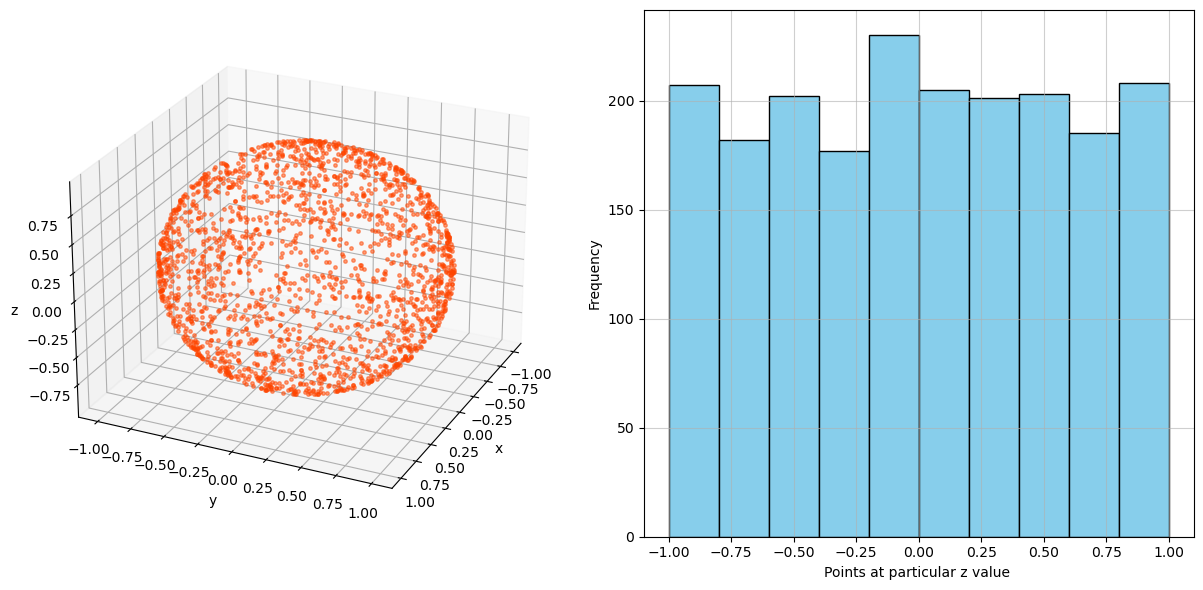

In [10]:
def isotropic_unit_vectors_fn(r, lower_limit_1d, upper_limit_1d, number_samples):
    """
    Generate isotropic unit vectors in 3D space.

    Parameters:
    r (float): Radius of the sphere.
    lower_limit_1d (float): Lower limit for the random number generation.
    upper_limit_1d (float): Upper limit for the random number generation.
    number_samples (int): Number of samples to generate.

    Returns:
    list: A list of x, y, z coordinates.
    float: Theta angle.
    float: Phi angle.
    """
    # Generate a random number within the specified limits
    random_number = random_number_fn(lower_limit_1d, upper_limit_1d, number_samples, 1)
    
    # Calculate theta using the inverse cosine function
    theta = np.arccos(1 - 2*random_number)
    
    # Uncomment the line below as mentioned in markdown cell below 
    #theta = random_number_fn(0, np.pi, number_samples, 1)
    
    # Calculate phi using the random number function
    phi = random_number_fn(0, 2*np.pi, number_samples, 1)
    
    # Calculate the sine of theta
    sin_theta = np.sin(theta)
    
    # Calculate the x, y, and z coordinates
    x = r * sin_theta * np.cos(phi)
    y = r * sin_theta * np.sin(phi)
    z = r * np.cos(theta)
    
    return [x, y, z], theta, phi

# Define the parameters
lower_limit_1d = 0
upper_limit_1d = 1
number_samples = 2000
r = 1

# Generate the isotropic unit vectors
sphere_points_3d, _, _ = isotropic_unit_vectors_fn(r, lower_limit_1d, upper_limit_1d, number_samples)

# Create a figure with two subplots
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection='3d')  
ax2 = fig.add_subplot(122)  

# Plot the 3D points on the first subplot
ax1.plot(np.ndarray.flatten(sphere_points_3d[0]), np.ndarray.flatten(sphere_points_3d[1]),
        np.ndarray.flatten(sphere_points_3d[2]), marker='.', c='orangered',
        linestyle='None', markersize = 5.0, alpha=0.5)
ax1.view_init(elev = 25, azim = 25)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Flatten the z-coordinates
heights = np.ndarray.flatten(sphere_points_3d[2])

# Create a histogram of the z-coordinates on the second subplot
ax2.hist(heights, bins=10, color='skyblue', edgecolor='black')
ax2.set_xlabel('Points at particular z value ')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

This plot confirms that the points are uniformly distributed, and that the points are not more dense in one region than another. The reader is welcome to uncomment a line of code below the theta definition if they wish to see what would happen to the distribution of points if the density at poles was not accounted for.

### Application to an exponential distribution of points

Isotropic unit vectors must be distributed according to an exponential distribution for this project, not the normal distribution as before. This is quite simple, as the code for the inverse cumulative distribution function already exists. The code for isotropic unit vectors distributed according to an exponential distribution is below, using the mean free path of water, $0.45$m.

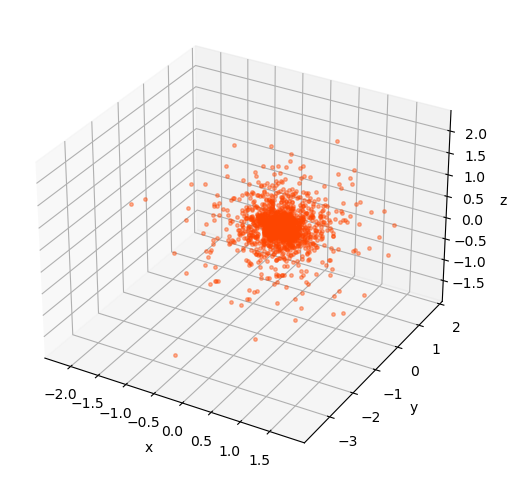

In [11]:
def exponential_radius(r, number_samples, meanfreepath):
    """
    Generate a radius following an exponential distribution.

    Parameters:
    r (float): Maximum radius.
    number_samples (int): Number of samples to generate.
    meanfreepath (float): Mean free path for the exponential distribution.

    Returns:
    float: Radius following an exponential distribution.
    """
    # Define the limits for the random number generation
    lower_limit = 0
    upper_limit = r
    
    # Generate a random number following an exponential distribution
    exponential_radius = exp_random_number_fn(lower_limit, upper_limit, number_samples, 1, meanfreepath)
    
    return exponential_radius


def exponential_unit_vectors(number_samples, meanfreepath):
    """
    Generate unit vectors in 3D space following an exponential distribution.

    Parameters:
    number_samples (int): Number of samples to generate.
    meanfreepath (float): Mean free path for the exponential distribution.

    Returns:
    list: A list of x, y, z coordinates.
    float: Theta angle.
    float: Phi angle.
    """
    # Define the limits for the random number generation
    lower_limit_1d = 0
    upper_limit_1d = 1
    
    # Generate a radius following an exponential distribution
    radius = exponential_radius(1, number_samples, meanfreepath)
    
    # Generate the isotropic unit vectors
    sphere_points_3d, theta, phi = isotropic_unit_vectors_fn(radius, lower_limit_1d, upper_limit_1d, number_samples)
    
    return sphere_points_3d, theta, phi

# Generate the exponential unit vectors
exponential_sphere_points, _, _ = exponential_unit_vectors(2000, 0.45)

# Create a figure
fig = plt.figure(figsize=(12,6))

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')  

# Plot the 3D points
ax.plot(np.ndarray.flatten(exponential_sphere_points[0]), np.ndarray.flatten(exponential_sphere_points[1]),
        np.ndarray.flatten(exponential_sphere_points[2]), marker='.', linestyle='None', markersize = 5.0,
        c='orangered', alpha=0.4)

# Set the labels for the axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Show the plot
plt.show()

This sphere appears to follow an exponential distribution. 

## Determining material properties

The macroscopic cross section, $\Sigma$, is the total cross section that is dependent on the number of absorbing molecules and the microscropic cross section. It has been previously calculated for water, however, only the scattering cross section, $\sigma_s$, was considered. To calculate the total macroscopic cross section, all processes must be considered,

$$
\Sigma_{total} = N(\sigma_s + \sigma_a) = \Sigma_s + \Sigma_a,
$$

where $\sigma_s$, $\sigma_a$ are the microscopic scattering and absorption cross sections, and $\Sigma_s$, $\Sigma_a$ are the macroscopic scattering and absorption cross sections.

With these values, the total mean free path can be calculated, 

$$
\lambda_{total} = \frac{1}{\Sigma_{total}},
$$

where $\lambda_{total}$ is the total mean free path. Another value which can be calculated is the probability of each process occuring, using the macroscopic cross section. This value is useful in determining the random walk of a neutron in each material, 

$$
\begin{align}
P_a = \frac{\Sigma_a}{\Sigma_a + \Sigma_s}, && P_s = \frac{\Sigma_s}{\Sigma_a + \Sigma_s}.
\end{align}
$$

In [12]:
def total_meanfreepath_calc(absorption_micro, scattering_micro, density, molar_mass):
    """
    Calculates the total, scattering and absorption mean free path for each material. Converts the microscopic
    cross-section from barns to m^2.
    
    Parameters:
        absorption_micro (float): Microscopic absorption cross-section, barns
        scattering_micro (float): Microscopic scattering cross-section, barns
        density (float): Density of material, g / cm^3
        molar_mass (float): Molar mass of material, g / mol
        
    Returns:
        total_meanfreepath (float): Total estimated mean free path, m
        scattering_meanfreepath (float): Scattering mean free path, m
        absorption_meanfreepath (float): Absorption mean free path, m
        
    """
    # Calculate the number of absorbing molecules
    number_absorbing_molecules = (density*10**6*constants.Avogadro)/(molar_mass)
    
    # Calculate both macroscopic cross-sections
    macro_cross_section_scattering = number_absorbing_molecules * (scattering_micro * 10**-28)
    macro_cross_section_absorption = number_absorbing_molecules * (absorption_micro * 10**-28)
    
    total_cross_section = macro_cross_section_scattering + macro_cross_section_absorption
    
    # Calculate probabilities of each process + total mean free path
    total_meanfreepath = 1 / total_cross_section
    probability_scattering = macro_cross_section_scattering / total_cross_section
    probability_absorption = macro_cross_section_absorption / total_cross_section
    
    return total_meanfreepath, probability_scattering, probability_absorption, total_cross_section

# Initialising lists
total_mfp_list = []
scattering_probability_list = []
absorption_probability_list = []
total_cross_section_list = []

# Appending values to lists
for absorption, scattering, density, molar_mass in zip(ABSORPTION, SCATTERING, DENSITY, MOLAR_MASS):
    total_mfp, scattering_probability, absorption_probability, total_cross_section = total_meanfreepath_calc(absorption, scattering, density, molar_mass)
    total_mfp_list.append(total_mfp)
    scattering_probability_list.append(scattering_probability)
    absorption_probability_list.append(absorption_probability)
    total_cross_section_list.append(total_cross_section)

## Visualising neutron random walk

Considering the system at hand, the random walk of a few neutrons is calculated through each material, for a slab of thickness $L$. This is placed between $x=0$ and $x=L$. Each neutron enters the slab perpendicularly from its left side at $x=0$, and is initially along the $+\hat{x}$ direction. The random walk stops running if $x < 0$, $x > L$, or if the neutron is absorbed - this happens whenever a uniform randomly generated number between 0 and 1, $v$, is less than the absorption probability, $P_a$. Otherwise, the random walk continues, and each step in the random walk updates the radial component of a spherically uniform exponential random number distribution, $\vec{r}$.

This is visualised in 3D below.

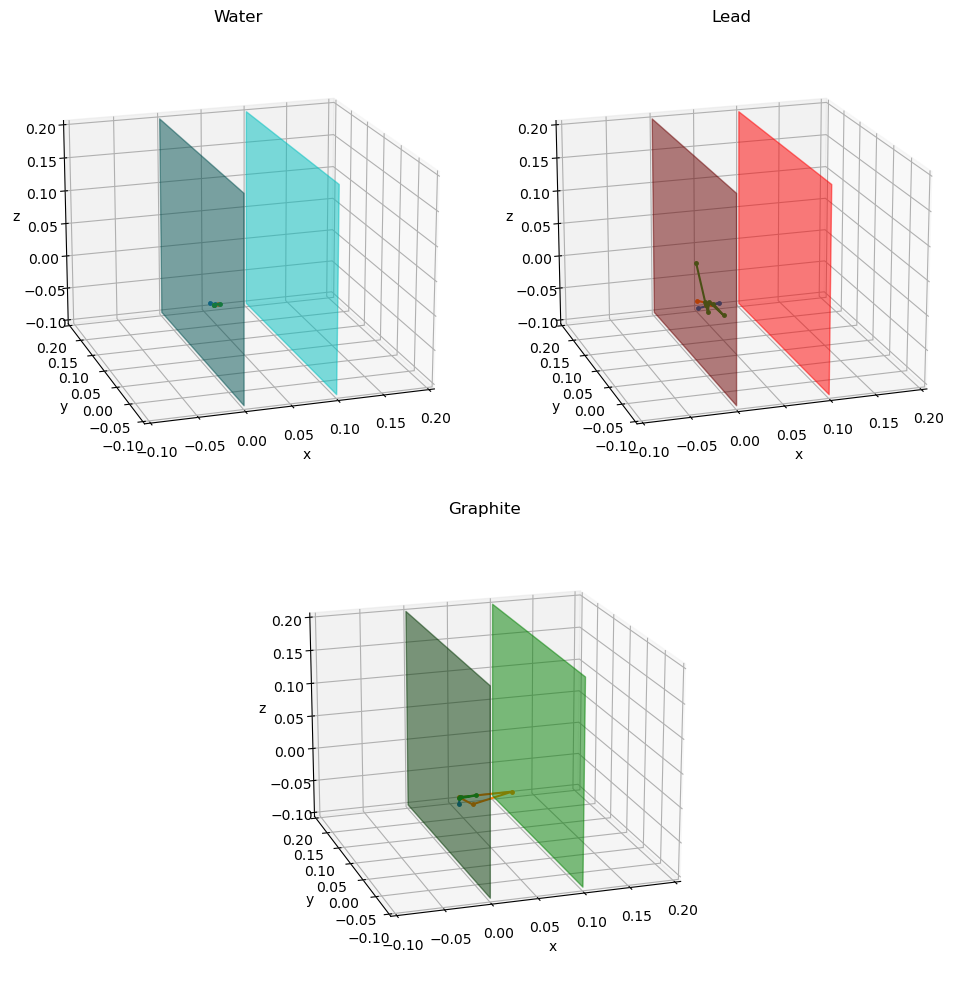

In [13]:
def neutron_visualisation(meanfreepath, probability_absorption, length):
    """
    Simulate the path of a neutron in a medium.

    Parameters:
        meanfreepath (float): Mean free path of the neutron.
        probability_absorption (float): Probability of neutron absorption.
        length (float): Length of the medium.

    Returns:
        random_walk (list): A list of x, y, z coordinates of the neutron's path.
    """
    # Initialize the coordinates
    x_coordinate = [0]
    y_coordinate = [0]
    z_coordinate = [0]

    # Calculate the first step
    x_coordinate.append(-meanfreepath * np.log(np.random.uniform(0, 1, 1)[0]))
    y_coordinate.append(0)
    z_coordinate.append(0)
    
    # Continue the walk until the neutron is absorbed or leaves the medium
    while 0 < x_coordinate[-1] < length:
        random_number = np.random.uniform(0, 1, 1)
        
        # Generate a step in a random direction
        xyz_array_exp, _, _ = exponential_unit_vectors(1, meanfreepath)
        x_coordinate.append(np.ndarray.flatten(xyz_array_exp[0])[0])
        y_coordinate.append(np.ndarray.flatten(xyz_array_exp[1])[0])
        z_coordinate.append(np.ndarray.flatten(xyz_array_exp[2])[0])
        
        # Check if the neutron is absorbed
        if random_number[0] < probability_absorption:
            break
        
    # Return the path of the neutron
    random_walk = [x_coordinate, y_coordinate, z_coordinate]
    return random_walk


def plot_walks(ax, walks, color, title):
    """
    Plot the paths of multiple neutrons.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        walks (list): A list of neutron paths.
        color (str): The color of the paths.
        title (str): The title of the plot.
    
    Returns:
        None
    """
    # Plot each walk
    for i in walks:
        ax.plot(i[0], i[1], i[2], marker='.', markersize = 5.0)
    
    # Set the labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)
    
    # Set the limits of the plot
    ax.set_xlim(-0.1, 0.2)
    ax.set_ylim(-0.1, 0.2)
    ax.set_zlim(-0.1, 0.2)
    
    # Set the view angle
    ax.view_init(elev=18, azim=-108)
    
    # Draw the planes representing the boundaries of the medium
    y = np.linspace(-0.1, 0.2, 2)
    z = np.linspace(-0.1, 0.2, 2)
    Y, Z = np.meshgrid(y, z)
    ax.plot_surface(np.zeros((2,2)), Y, Z, alpha=0.5, facecolors=color, rstride=100, cstride=100)
    ax.plot_surface(length*np.ones((2,2)), Y, Z, alpha=0.5, facecolors=color, rstride=100, cstride=100, shade=False) 
    return None

# Set parameters
length = 0.1
number_walks = 3

# Plots
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221, projection='3d')   
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(212, projection='3d')

# Simulate 3D random walks in each material
walks_water = [neutron_visualisation(total_mfp_list[0], absorption_probability_list[0], length) for _ in range(number_walks)]
walks_lead = [neutron_visualisation(total_mfp_list[1], absorption_probability_list[1], length) for _ in range(number_walks)]
walks_graphite = [neutron_visualisation(total_mfp_list[2], absorption_probability_list[2], length) for _ in range(number_walks)]

plot_walks(ax1, walks_water, 'c', 'Water')
plot_walks(ax2, walks_lead, 'r', 'Lead')
plot_walks(ax3, walks_graphite, 'g', 'Graphite')

plt.tight_layout()
plt.show()

The three different colours within the slab, marked by the planes at $x=0$ and $x=L$, represent three different random walks in the same material.

Each material has a significantly different random walk, and this is because of their different scattering and absorption cross-sections. Water has the largest absorption cross-section, so many neutrons are absorbed, and this is shown by their short path in the 3D random walk. Graphite has the smallest absorption cross-section, so many more scattering events can be seen. Lead lies somewhere in the middle of these two.

The scattering, absorption and transmission rates are more accurately calculated in the next section.

## Quantifying scattering processes

To accurately quantify each process that is occuring, the code that induces a random walk must be optimized in order for it to run for a large number of neutrons. The number of neutrons that is chosen is 10,000 neutrons. This will then be iterated over in order to calculate any statistical variations that occur due to the processes being calculated entirely by random numbers.

The neutron simulation for $\mathrm{N}$ neutrons is coded below. The function itself is optimised using NumPy functions. This speeds up the code significantly, as opposed to for loops with logic statements like "if" or "elif" statements. Arrays are set up in Python, and NumPy carries out its operations in C, which is not a dynamic programming language, and is more efficient at performing large calculations than Python. All of the neutrons take the first step in the $\hat{x}$ direction, and np.argwhere is used to calculate neutrons which are backscattered and transmitted. The neutrons that are absorbed are calculated using a probability, $P_{abs}$, and a random number. All of these instances are tallied using np.count_nonzero, and then the neutrons which are detected to be absorbed/backscattered/transmitted in one loop are deleted using np.delete. The while loop keeps on running until all of the neutrons have been deleted, and the tallies are completed.

In [14]:
def neutron_simulation(N, meanfreepath, L, scattering_probability, absorption_probability):
    """
    Simulate the path of a neutron in a medium and count the number of scattering, absorption, and transmission occurrences.

    Parameters:
        N (int): Total number of neutrons.
        meanfreepath (float): Mean free path of the neutron.
        L (float): Length of the medium.
        scattering_probability (float): Probability of neutron scattering.
        absorption_probability (float): Probability of neutron absorption.

    Returns:
        scattering_occurence (int): Number of scattering occurrences.
        absorption_occurence (int): Number of absorption occurrences.
        transmission_occurence (int): Number of transmission occurrences.
        scattering_rate (float): Rate of scattering occurrences.
        absorption_rate (float): Rate of absorption occurrences.
        transmission_rate (float): Rate of transmission occurrences.
    """
    # Set the count of each occurence to 0
    scattering_occurence = 0
    absorption_occurence = 0
    transmission_occurence = 0
    
    # Generate an exponentially distributed random number
    displacement = -meanfreepath * np.log(np.random.uniform(0, 1, N))
    
        
    while len(displacement) > 0: 
        # Generate a uniform random number for each instance, with the size of the length of the x_coordinate array
        uniform_rand = np.random.uniform(size=len(displacement))
        
        # Count the number of instances of each process using numpy functions to decrease computation time
        scattering_occurence += np.count_nonzero(displacement < 0)
        absorption_occurence += np.count_nonzero(uniform_rand[np.argwhere((displacement > 0) & (displacement < L))] < absorption_probability)
        transmission_occurence += np.count_nonzero(displacement > L)
        
        # Delete the neutrons that lie outside of the absorption probability, and outside of the region of interest
        displacement = np.delete(displacement, np.argwhere((uniform_rand < absorption_probability) | (displacement < 0) | (displacement > L)))
        exponential_sphere_points, _, _ = exponential_unit_vectors(len(displacement), meanfreepath)
        isotropic_step = exponential_sphere_points[0]
        
        displacement += np.ndarray.flatten(isotropic_step)
        
    scattering_rate = scattering_occurence / N
    absorption_rate = absorption_occurence / N
    transmission_rate = transmission_occurence / N
    return scattering_occurence, absorption_occurence, transmission_occurence, scattering_rate, absorption_rate, transmission_rate

The above function calculates the scattering, absorption and transmission counts, and also calculates their rate, $N_{process}\,/\,N_{total}$, where $N_{total}$ is the total number of neutrons, and $N_{process}$ is the number of neutrons that are counted for each process.

This must be iterated over in order to achieve an error quantification, and this is done for water, lead and graphite, for $N_{iterations} = $ 10. The scattering, absorption and transmission rates are printed for each material, with an error that corresponds to the standard deviation on each rate. 

In [15]:
def material_rates(N, meanfreepath, length, scattering_probability, absorption_probability, number_iterations):
    """
    This function simulates the neutron scattering, absorption, and transmission rates for a given material.

    Parameters:
        N (int): The number of neutrons.
        meanfreepath (float): The mean free path of the neutrons.
        length (float): The length of the cavity.
        scattering_probability (float): The probability of neutron scattering.
        absorption_probability (float): The probability of neutron absorption.
        number_iterations (int): The number of iterations for the simulation.

    Returns:
        means[0] (float): Mean scattering rate
        means[1] (float): Mean absorption rate
        means[2] (float): Mean transmission rate
        stds[0] (float): Standard deviation of scattering rate
        stds[1] (float): Standard deviation of absorption rate
        stds[2] (float): Standard deviation of transmission rate
        number_s (int): Number of scatterings
        number_a (int): Number of absorptions
        number_t (int): Number of transmissions
    """
    results = []
    for i in range(number_iterations):
        number_s, number_a, number_t, scattering_rate, absorption_rate, transmission_rate = neutron_simulation(N, meanfreepath, length, scattering_probability, absorption_probability)
        results.append([scattering_rate, absorption_rate, transmission_rate])
    
    results = np.array(results)
    means = np.mean(results, axis=0)
    stds = np.std(results, axis=0)
    
    return means[0], means[1], means[2], stds[0], stds[1], stds[2], number_s, number_a, number_t

def print_results(material, N, length, number_iterations, results):
    """
    This function prints the results of the neutron simulation for a given material.

    Parameters:
        material (str): The name of the material.
        N (int): The number of neutrons.
        length (float): The length of the cavity.
        number_iterations (int): The number of iterations for the simulation.
        results (list): The results of the neutron simulation.

    Returns:
        None
    """
    print(f'{material} \n'
         f'----- \n'
         f'Number of neutrons = {N} \n'
         f'Length of cavity = {length*100} cm \n'
         f'Number of iterations = {number_iterations} \n'
         f'----- \n'
         f'Rate of scattering = {results[0] * 100:.2f} +/- {results[3] * 100:.2f} % \n'
         f'Rate of absorption = {results[1] * 100:.2f} +/- {results[4] * 100:.2f} % \n'
         f'Rate of transmission = {results[2] * 100:.2f} +/- {results[5] * 100:.2f} % \n'
         '\n'
         '--- \n')
    return None
N = 10000
length = 0.1
number_iterations = 10

# Water
results = material_rates(N, total_mfp_list[0], length, scattering_probability_list[0], absorption_probability_list[0], number_iterations)
print_results('Water', N, length, number_iterations, results)

# Lead
results = material_rates(N, total_mfp_list[1], length, scattering_probability_list[1], absorption_probability_list[1], number_iterations)
print_results('Lead', N, length, number_iterations, results)

# Graphite
results = material_rates(N, total_mfp_list[2], length, scattering_probability_list[2], absorption_probability_list[2], number_iterations)
print_results('Graphite', N, length, number_iterations, results)

Water 
----- 
Number of neutrons = 10000 
Length of cavity = 10.0 cm 
Number of iterations = 10 
----- 
Rate of scattering = 79.56 +/- 0.33 % 
Rate of absorption = 20.11 +/- 0.35 % 
Rate of transmission = 0.33 +/- 0.07 % 

--- 

Lead 
----- 
Number of neutrons = 10000 
Length of cavity = 10.0 cm 
Number of iterations = 10 
----- 
Rate of scattering = 61.99 +/- 0.57 % 
Rate of absorption = 9.96 +/- 0.24 % 
Rate of transmission = 28.04 +/- 0.69 % 

--- 

Graphite 
----- 
Number of neutrons = 10000 
Length of cavity = 10.0 cm 
Number of iterations = 10 
----- 
Rate of scattering = 68.40 +/- 0.31 % 
Rate of absorption = 0.76 +/- 0.07 % 
Rate of transmission = 30.85 +/- 0.33 % 

--- 



The above rates appear to approximately match the random walk visualisation, and they all have reasonable errors calculated.

By employing appropriate numpy functions like np.count_nonzero, np.argwhere, np.delete, etc., you should be able to finish the entire calculation for each thickness within a few seconds, even for 10,000 neutrons and 10 iterations.

As for the range and number of thicknesses, 1cm to 20cm in increments of 1cm is recommended.

To derive the attenuation length, start by computing the mean and standard deviation of transmission at each thickness value. Then, perform a linear fitting using np.polyfit for log(mean_transmission) versus thickness, weighted by 1/error, where error is std_transmission/mean_transmission.

## Plotting variations

The variation in neutron transmission, reflection and absorption rates with slab thickness is investigated through plotting the rates against slab thickness for all three materials. The variation in slab thickness in the range $1-20\,$cm will be investigated.

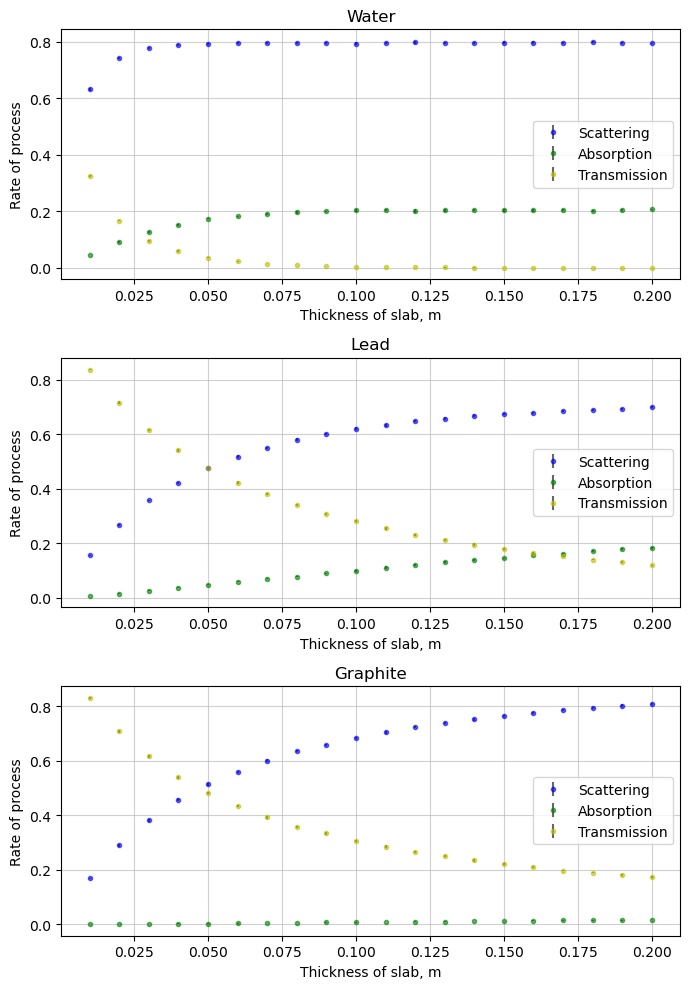

In [16]:
def length_variation(N, meanfreepath, scattering_probability, absorption_probability, number_iterations, length_array):
    """
    Simulates neutron interactions over a range of material lengths and computes rates of scattering, absorption, and transmission.

    Parameters:
        N (int): Number of neutrons.
        meanfreepath (float): Mean free path of neutrons in the material.
        scattering_probability (float): Probability of scattering for neutrons in the material.
        absorption_probability (float): Probability of absorption for neutrons in the material.
        number_iterations (int): Number of iterations for averaging results.
        length_array (array-like): Array of material lengths to simulate.

    Returns:
        tuple: Contains scattering, absorption, and transmission rates along with their respective errors for each material length.
    """
    # Calculate rates and errors for each length in length_array
    results = [material_rates(N, meanfreepath, length, scattering_probability, absorption_probability, number_iterations) for length in length_array]
    
    # Extract scattering rates and errors
    scattering_length_variation, scattering_error = zip(*[(result[0], result[3]) for result in results])
    
    # Extract absorption rates and errors
    absorption_length_variation, absorption_error = zip(*[(result[1], result[4]) for result in results])
    
    # Extract transmission rates and errors
    transmission_length_variation, transmission_error = zip(*[(result[2], result[5]) for result in results])
  
    return scattering_length_variation, absorption_length_variation, transmission_length_variation, scattering_error, absorption_error, transmission_error

def plot_results(ax, length_array, length_variations, title):
    """
    Plots the results of neutron interaction simulations.

    Parameters:
        ax (matplotlib.axes.Axes): Matplotlib Axes object to plot on.
        length_array (array-like): Array of material lengths.
        length_variations (tuple): Contains scattering, absorption, and transmission rates and their errors.
        title (str): Title for the plot.
        
    Returns:
        None
    """
    # Plot scattering rates with error bars
    ax.errorbar(length_array, length_variations[0], yerr=length_variations[3], fmt='.', ecolor='k', label='Scattering', color='b', alpha=0.6)
    
    # Plot absorption rates with error bars
    ax.errorbar(length_array, length_variations[1], yerr=length_variations[4], fmt='.', ecolor='k', label='Absorption', color='g', alpha=0.6)
    
    # Plot transmission rates with error bars
    ax.errorbar(length_array, length_variations[2], yerr=length_variations[5], fmt='.', ecolor='k', label='Transmission', color='y', alpha=0.6)
    
    # Set plot title and labels
    ax.set_title(title)
    ax.grid(True, alpha=0.6)
    ax.set_xlabel('Thickness of slab, m')
    ax.set_ylabel('Rate of process')
    ax.legend()
    return None

# Array of different lengths to be iterated over, in the range 0.01 - 0.2 m.
length_array = np.linspace(0.01, 0.2, 20)

# Simulate and plot results for different materials

# Water
length_variations_water = length_variation(N, total_mfp_list[0], scattering_probability_list[0], absorption_probability_list[0], number_iterations, length_array)

# Lead
length_variations_lead = length_variation(N, total_mfp_list[1], scattering_probability_list[1], absorption_probability_list[1], number_iterations, length_array)

# Graphite
length_variations_graphite = length_variation(N, total_mfp_list[2], scattering_probability_list[2], absorption_probability_list[2], number_iterations, length_array)

# Create figure and subplots
fig = plt.figure(figsize=(7, 10))

# Plot results for Water
ax1 = fig.add_subplot(3, 1, 1)
plot_results(ax1, length_array, length_variations_water, 'Water')

# Plot results for Lead
ax2 = fig.add_subplot(3, 1, 2)
plot_results(ax2, length_array, length_variations_lead, 'Lead')

# Plot results for Graphite
ax3 = fig.add_subplot(3, 1, 3)
plot_results(ax3, length_array, length_variations_graphite, 'Graphite')

plt.tight_layout()
plt.show()

The plotted error bars are close to not being visible as they are too small - the opacity of the plotted points themselves was reduced in order to display the error. The error on each point can be seen as essentially a black dot.

## Determining attenuation length

In order to determine the attenuation length, the log of the mean transmission against the thickness is plotted. The function np.polyfit is then used to find the gradient of this graph, which corresponds to $1\,/\,\lambda_{att}$, where $\lambda_{att}$ is the attenuation length, m, of the material. This is the average length it takes for the rate to drop to $1 / e$ of its original value.

The attenuation length of Water is calculated to be 1.90 ± 0.04 cm. 
The chi-squared of Water is 86, and the reduced chi-squared is 4.8.

The attenuation length of Lead is calculated to be 9.01 ± 0.25 cm. 
The chi-squared of Lead is 8.1e+02, and the reduced chi-squared is 44.9.

The attenuation length of Graphite is calculated to be 10.62 ± 0.46 cm. 
The chi-squared of Graphite is 1.9e+03, and the reduced chi-squared is 104.



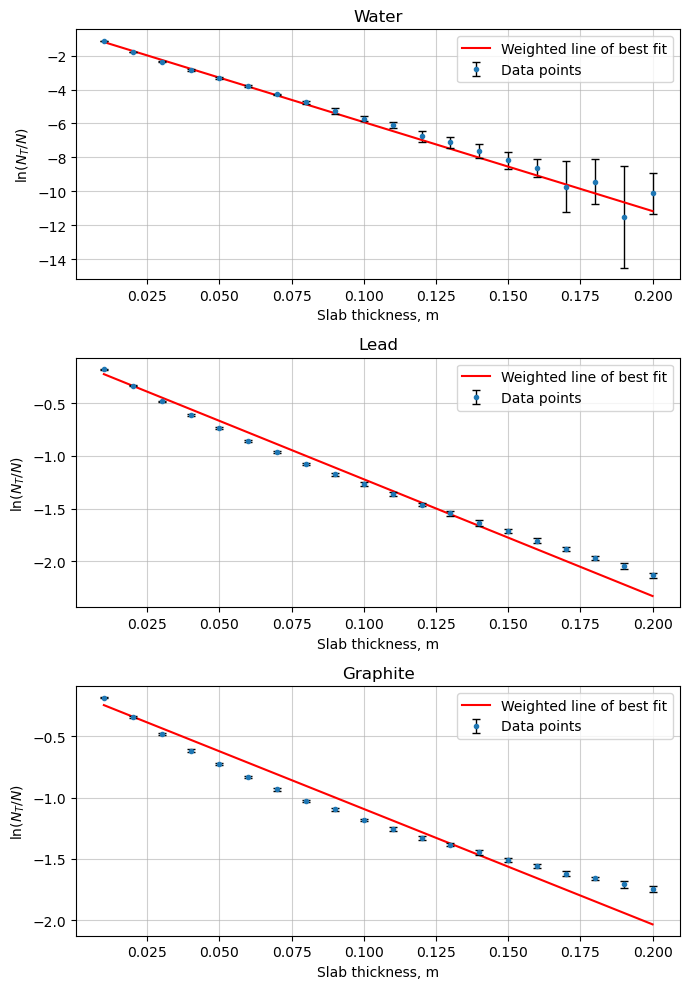

In [17]:
def error_weighting(standard_deviation, mean):
    """
    Finds the weighted error for a np.polyfit fitting on each point.
    
    Parameters:
        standard_deviation (array-like): Standard deviations of the data points.
        mean (array-like): Mean values of the data points.
    
    Returns:
    - weighted_error (array-like): The weighted errors for each data point.
    """
    weighted_error = standard_deviation / mean
    return weighted_error

def chi_squared_fn(y_data, y_predicted, y_error):
    """
    Performs a chi-squared test to compare the data and its errors to a model function.
    
    Parameters:
        y_data (array-like): The experimental data in y.
        y_predicted (array-like): The predicted y data based on a model function.
        y_error (array-like): The errors on the experimental data, the standard deviations.
    
    Returns:
        chi_squared (float): The chi-squared value.
        reduced_chi_squared (float): The reduced chi-squared value considering degrees of freedom.
    """
    chi_squared = np.sum(((y_data - y_predicted) / y_error) ** 2)
    reduced_chi_squared = chi_squared / (len(y_data) - 2)
    return chi_squared, reduced_chi_squared

def plot_graph(ax, length_variations, length_array, title):
    """
    Plots the transmission rates with error bars and a weighted line of best fit.
    
    Parameters:
        ax (matplotlib.axes.Axes): Matplotlib Axes object to plot on.
        length_variations (tuple): Contains scattering, absorption, and transmission rates and their errors.
        length_array (array-like): Array of material lengths.
        title (str): Title for the plot.
        
    Returns:
        None
    """
    # Extracting transmission rates and their errors from length_variations
    transmission_rates = np.array(length_variations[2])
    transmission_errors = np.array(length_variations[5])
    
    # Filtering out zero transmission rates
    indices = [i for i, x in enumerate(transmission_rates) if x == 0]
    transmission_rates = [i for i in transmission_rates if i != 0]
    transmission_errors = [i for j, i in enumerate(transmission_errors) if j not in indices]
    length_array = [i for j, i in enumerate(length_array) if j not in indices]
    
    # Calculating the weighted error
    weighted_error = error_weighting(np.array(transmission_errors), np.array(transmission_rates))
    
    # Performing a weighted fit to a straight line
    polyfit = polyfit_fn(length_array, np.log(transmission_rates), 1, weighted_error)
    
    # Calculating chi-squared and reduced chi-squared values
    chi_squared_fit, reduced_chi_fit = chi_squared_fn(np.log(transmission_rates), (polyfit[0] * np.array(length_array) + polyfit[1]), weighted_error)
    
    # Calculating the attenuation length from the gradient of the fit
    attenuation_length = -1 / polyfit[0]
    error_attenuation_length = attenuation_length * np.sqrt((polyfit[2] / polyfit[0]) ** 2)
    
    # Plotting the data points and the fitted line
    ax.plot(length_array, (polyfit[0] * np.array(length_array) + polyfit[1]), color='r', label='Weighted line of best fit')
    ax.errorbar(length_array, np.log(transmission_rates), yerr=weighted_error, linestyle='', marker='.', ecolor='k', elinewidth=1, capsize=3, label='Data points')
    ax.grid(True, alpha=0.6)
    ax.set_xlabel('Slab thickness, m')
    ax.set_ylabel('$\mathrm{ln}(N_T/N)$')
    ax.set_title(title)
    ax.legend()
    
    # Printing the calculated attenuation length and chi-squared values
    print(f'The attenuation length of {title} is calculated to be {attenuation_length * 100:.2f} ± {error_attenuation_length * 100:.2f} cm. \n'
          f'The chi-squared of {title} is {chi_squared_fit:.2g}, and the reduced chi-squared is {reduced_chi_fit:.3g}.\n')
    return None

# Assuming length_variations_water, length_variations_lead, length_variations_graphite, and length_array are defined

# Plotting the data and lines of best fit for different materials
fig = plt.figure(figsize=(7, 10))

# Plotting for Water
ax1 = fig.add_subplot(3, 1, 1)
plot_graph(ax1, length_variations_water, length_array, 'Water')

# Plotting for Lead
ax2 = fig.add_subplot(3, 1, 2)
plot_graph(ax2, length_variations_lead, length_array, 'Lead')

# Plotting for Graphite
ax3 = fig.add_subplot(3, 1, 3)
plot_graph(ax3, length_variations_graphite, length_array, 'Graphite')

plt.tight_layout()
plt.show()

The $\chi^2$ and reduced $\chi^2$ of water are the smallest as it has the largest error bars, therefore being better aligned with the line of best fit. The other two materials, lead and graphite, have larger $\chi^2$ values as the error bars are smaller, and their data is further away from being a straight line. 

The attenuation length calculated includes absorption and scattering probabilities, unlike earlier in the project when the attenuation length of water was determined using only the absorption probability. 

Water has the lowest attenuation length, possibly due to its high absorption cross-section compared to the other materials, and the high probability of scattering events - around $10\times$ bigger than both of the other materials. Water is a very good neutron moderator due to its large scattering cross-section, as it can slow neutrons down particularly well. The neutrons are slowed because they lose energy in collisions with the material in each scattering event. The fact that water is a liquid provides a benefit outside of simulation, as it will be more uniform compared to a solid which may have small impurities in some locations. 

Lead has a similar attenuation length to graphite, however, the two materials differ in that both the absorption and scattering cross-section are higher in lead. Lead is the most dense material of the three, being around $10\times$ as dense. It can be determined from the results of the simulation that despite lead being much more dense than graphite, it is only a slightly better shielding material (better meaning that the attenuation length is shorter). This is because of the way neutrons interact with matter - if the collisions between neutrons and the nuclei of the material are similar in size, the neutrons are more slowed than if the nuclei were large. Therefore, lead is not a very efficient material to use as a neutron shield/moderator.  

Graphite has the highest attenuation length of the three materials. It has the lowest absorption and scattering cross-section of the three, but has quite a similar result to lead despite this. This is because it has a low atomic number of 6, meaning it is more similar in size to a neutron. It is a more efficient neutron shield than lead, due to the high density of lead - making it impractical to install instead of something like graphite.

## Woodcock method

In most nuclear reactors, more than two materials are used as a shielding layer from neutrons. If two slabs of different materials are against each other, the previous method fails. This is because it can overstep from one region to the other, causing any further calculation to be incorrect. It cannot account for the movement from one region into another properly.

Another method of calculating each process is called the Woodcock method. It differs from the previous method in that it introduces fictious steps. As an example to see how this works, consider two slabs of material with different cross sections, $\Sigma_1$ and $\Sigma_2$, beside each other. The region where the cross-section is larger, i.e., $\Sigma_1 < \Sigma_2$, is chosen, and called the majorant cross-section, $\Sigma_T$. In this example, $\Sigma_T = \Sigma_2$. A larger cross-section corresponds to a shorter mean free path, $\lambda$, meaning $\lambda_1 > \lambda_2$. The step size is calculated according to the shorter mean free path, $\lambda_2 = \lambda_T$ in this case. The step size is calculated using the exponential inverse CDF as before, $s_i = -\lambda_T\,\mathrm{ln}\left(u_i\right)$. 

In [18]:
def neutron_simulation_woodcock(N, meanfreepath1, meanfreepath2, cross_section_1, cross_section_2, probability_absorption_1, probability_absorption_2, L):
    meanfreepath_t = np.min([meanfreepath1, meanfreepath2])
    cross_section_min = np.min([cross_section_1, cross_section_2])
    cross_section_max = np.max([cross_section_1, cross_section_2])
    
    # Set the count of each occurrence to 0
    scattering_occurence = 0
    absorbed_1 = 0
    absorbed_2 = 0
    transmission_occurence = 0
    
    displacement = -meanfreepath_t * np.log(np.random.uniform(0, 1, N))
    theta = np.full(len(displacement), np.pi / 2)
    phi = np.zeros(len(displacement))
    
    probability_fictious = cross_section_min / cross_section_max
    
    while len(displacement) > 0:
        
        # Fictious steps array
        fictious = np.full(len(displacement), False) 
        # Add to scattering/transmission tallies
        scattering_occurence += np.count_nonzero(displacement < 0)
        transmission_occurence += np.count_nonzero(displacement > 2*L)
        
        # Find indices to delete
        indices_to_delete = np.argwhere((displacement < 0) | (displacement > 2*L))
    
        # Delete neutrons that are scattered/transmitted
        displacement = np.delete(displacement, indices_to_delete)
        theta = np.delete(theta, indices_to_delete)
        phi = np.delete(phi, indices_to_delete)
        fictious = np.delete(fictious, indices_to_delete)
        
        # Generate random number to check for probabilities
        random_number_check_fict = np.random.uniform(0, 1, size=len(displacement))
        fictious[np.argwhere((displacement > 0) & (displacement < L) & (random_number_check_fict > probability_fictious))] = True
        # Another random number is generated to remove absorbed neutrons
        random_number_check = np.random.uniform(0, 1, size=len(displacement))
        
        absorption_removal = np.argwhere((displacement > 0) & (displacement < L)
                                         & (random_number_check < probability_absorption_1) & (fictious == False) | 
                                        (displacement > L) & (displacement < 2*L) &
                                         (random_number_check < probability_absorption_2))
        
        # Absorption in material 1
        absorbed_1 += np.count_nonzero(np.argwhere((displacement > 0) & (displacement < L) & (random_number_check < probability_absorption_1)
                                                   & (fictious == False)))
        
        # Absorption in material 2
        absorbed_2 += np.count_nonzero(np.argwhere((displacement > L) & (displacement < 2*L) 
                                                   & (random_number_check < probability_absorption_2)))      
        # Remove absorbed neutrons
        displacement = np.delete(displacement, absorption_removal)
        theta = np.delete(theta, absorption_removal)
        phi = np.delete(phi, absorption_removal)
        fictious = np.delete(fictious, absorption_removal) 
        
        # if fictious is true, this is the update condition
        isotropic_step, theta_unit_vectors, phi_unit_vectors = exponential_unit_vectors(len(displacement), meanfreepath_t)
        
        
        # Use np.where to conditionally update theta and phi whenever fictious is false
        theta = np.where(~fictious, theta + theta_unit_vectors.flatten(), theta)
        phi = np.where(~fictious, phi + phi_unit_vectors.flatten(), phi) 
        
        displacement += isotropic_step[0].flatten()
        
    the_sum = scattering_occurence + absorbed_1 + absorbed_2 + transmission_occurence
    scattering_rate = scattering_occurence / the_sum
    absorption_rate_1 = absorbed_1 / the_sum
    absorption_rate_2 = absorbed_2 / the_sum
    transmission_rate = transmission_occurence / the_sum
    return scattering_occurence, absorbed_1, absorbed_2, transmission_occurence, scattering_rate, absorption_rate_1, absorption_rate_2, transmission_rate

As in the previous method, the Woodcock method needs to be iterated over in order to calculate statistical deviances. This will help to gather a picture of how accurate the Woodcock method is, and how it compares to the previous method.

The Woodcock method will be iterated over 5 times, and the error calculated in the same manner as in the previous case.

In [19]:
def material_rates(N, meanfreepath1, meanfreepath2, cross_section_1, cross_section_2, probability_absorption_1, probability_absorption_2, L, number_iterations):
    """
    This function simulates the neutron scattering, absorption, and transmission rates for a given material.

    Parameters:
        N (int): Number of neutrons
        meanfreepath1 (float): Mean free path in material 1
        meanfreepath2 (float): Mean free path in material 2
        cross_section_1 (float): Cross section in material 1
        cross_section_2 (float): Cross section in material 2
        probability_absorption_1 (float): Absorption probability in material 1
        probability_absorption_2 (float): Absorption probability in material 2
        L (float): Length of the cavity
        number_iterations (int): Number of iterations for the simulation

    Returns:
        tuple: Mean and standard deviation of scattering rate, absorption rates (material 1 and 2), and transmission rate
    """
    results = []
    for i in range(number_iterations):
        simulation = neutron_simulation_woodcock(N, meanfreepath1, meanfreepath2, cross_section_1, cross_section_2, probability_absorption_1, probability_absorption_2, L)
        scattering_rate = simulation[4]
        absorption_rate_1 = simulation[5]
        absorption_rate_2 = simulation[6]
        transmission_rate = simulation[7]
        results.append([scattering_rate, absorption_rate_1, absorption_rate_2, transmission_rate])
    
    results = np.array(results)
    means = np.mean(results, axis=0)
    stds = np.std(results, axis=0)
    
    return means[0], means[1], means[2], means[3], stds[0], stds[1], stds[2], stds[3]

def print_results_woodcock(material, N, length, number_iterations, results):
    """
    This function prints the results of the neutron simulation for a given material.

    Parameters:
        material (str): The name of the material.
        N (int): The number of neutrons.
        length (float): The length of the cavity.
        number_iterations (int): The number of iterations for the simulation.
        results (list): The results of the neutron simulation.

    Returns:
        None
    """
    print(f'{material} \n'
         f'----- \n'
         f'Number of neutrons = {N} \n'
         f'Thickness of material 1 = {length*100} cm \n'
         f'Thickness of material 2 = {length*100} cm \n'   
         f'Number of iterations = {number_iterations} \n'
         f'----- \n'
         f'Rate of scattering = {results[0] * 100:.2f} +/- {results[4] * 100:.2f} % \n'
         f'Rate of absorption, material 1 = {results[1] * 100:.2f} +/- {results[5] * 100:.2f} % \n'
         f'Rate of absorption, material 2 = {results[2] * 100:.2f} +/- {results[6] * 100:.2f} % \n'
         f'Rate of transmission = {results[3] * 100:.2f} +/- {results[7] * 100:.2f} % \n'
         '\n'
         '--- \n')
    return None

number_iterations = 5
L = 0.05
N = 10000

# Water to water
water_rates = material_rates(N, total_mfp_list[0], total_mfp_list[0], total_cross_section_list[0],
               total_cross_section_list[0], absorption_probability_list[0], absorption_probability_list[0],
               L, number_iterations)
print_results_woodcock('Water', N,  L, number_iterations, water_rates)

# Lead to lead
lead_rates = material_rates(N, total_mfp_list[1], total_mfp_list[1], total_cross_section_list[1],
               total_cross_section_list[1], absorption_probability_list[1], absorption_probability_list[1],
               L, number_iterations)
print_results_woodcock('Lead', N,  L, number_iterations, lead_rates)

# Graphite to graphite
graphite_rates = material_rates(N, total_mfp_list[2], total_mfp_list[2], total_cross_section_list[2],
               total_cross_section_list[2], absorption_probability_list[2], absorption_probability_list[2],
               L, number_iterations)
print_results_woodcock('Graphite', N,  L, number_iterations, graphite_rates)

Water 
----- 
Number of neutrons = 10000 
Thickness of material 1 = 5.0 cm 
Thickness of material 2 = 5.0 cm 
Number of iterations = 5 
----- 
Rate of scattering = 79.54 +/- 0.31 % 
Rate of absorption, material 1 = 18.40 +/- 0.27 % 
Rate of absorption, material 2 = 1.76 +/- 0.23 % 
Rate of transmission = 0.29 +/- 0.04 % 

--- 

Lead 
----- 
Number of neutrons = 10000 
Thickness of material 1 = 5.0 cm 
Thickness of material 2 = 5.0 cm 
Number of iterations = 5 
----- 
Rate of scattering = 61.99 +/- 0.29 % 
Rate of absorption, material 1 = 6.70 +/- 0.34 % 
Rate of absorption, material 2 = 3.49 +/- 0.05 % 
Rate of transmission = 27.83 +/- 0.36 % 

--- 

Graphite 
----- 
Number of neutrons = 10000 
Thickness of material 1 = 5.0 cm 
Thickness of material 2 = 5.0 cm 
Number of iterations = 5 
----- 
Rate of scattering = 68.21 +/- 0.24 % 
Rate of absorption, material 1 = 0.49 +/- 0.07 % 
Rate of absorption, material 2 = 0.29 +/- 0.03 % 
Rate of transmission = 31.01 +/- 0.25 % 

--- 



The length of $5\mathrm{cm}$ can be used twice with two materials in order to compare to the previous results. From the above pi charts, it can be seen that the results do indeed match those gathered by the previous method. These results are visualised below in pie charts.

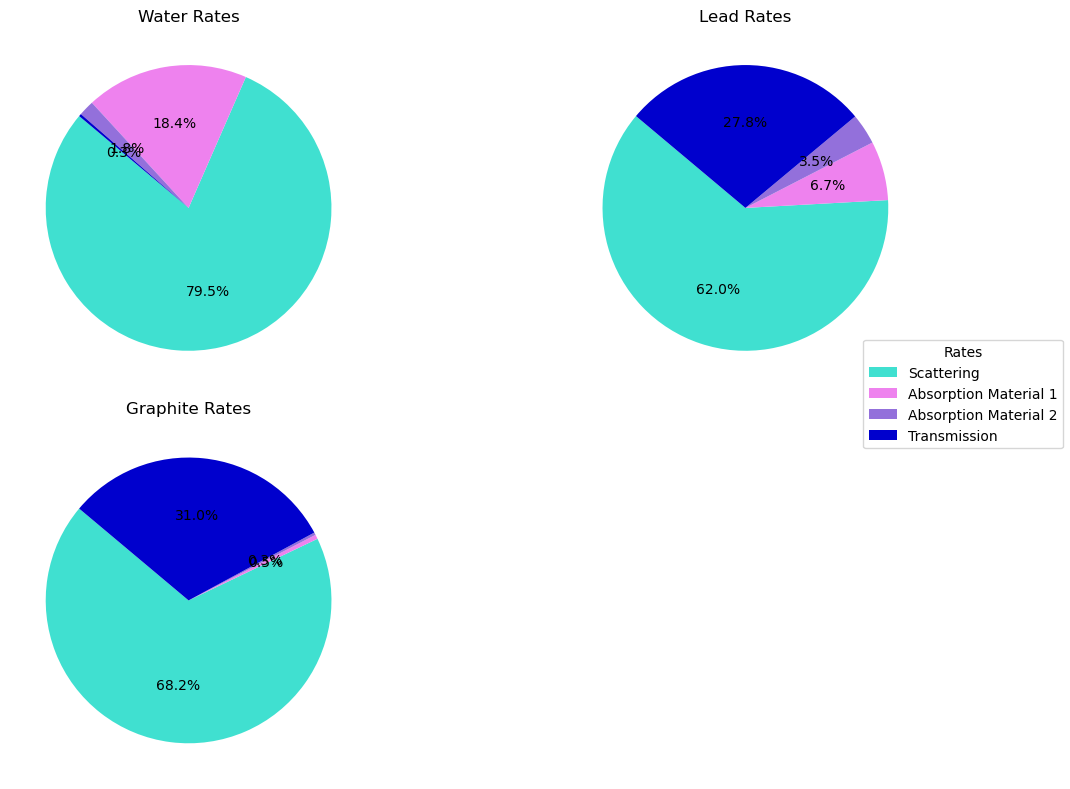

In [20]:
def plot_rates_pie(water_rates, lead_rates, graphite_rates, titles):
    labels = ['Scattering', 'Absorption Material 1', 'Absorption Material 2', 'Transmission']
    rates = [water_rates, lead_rates, graphite_rates]
    colors = ['turquoise', 'violet', 'mediumpurple', 'mediumblue']  # Blue, purple, pink, orange
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()
    
    for i, (ax, rate, title) in enumerate(zip(axs[:3], rates, titles)):
        wedges, texts, autotexts = ax.pie(rate[:4], colors=colors, autopct='%1.1f%%', startangle=140, normalize=False)
        ax.set_title(title)
        #ax.legend(wedges, labels, title="Rates", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    fig.legend(wedges, labels, title="Rates", loc="center right")
    # Hide the 4th subplot (bottom-right)
    axs[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    return None
titles = ['Water Rates', 'Lead Rates', 'Graphite Rates']
    
plot_rates_pie(water_rates, lead_rates, graphite_rates, titles)

Given the accuracy of the Woodcock method has been checked, the analysis including different materials side by side can be conducted. However, the material with the shorter mean free path always needs to be considered first due to the computational method. This means the results will be cut in half.

The materials tested are: water to lead, water to graphite, graphite to lead. 

Water to lead 
----- 
Number of neutrons = 10000 
Thickness of material 1 = 5.0 cm 
Thickness of material 2 = 5.0 cm 
Number of iterations = 5 
----- 
Rate of scattering = 90.57 +/- 0.32 % 
Rate of absorption, material 1 = 3.12 +/- 0.19 % 
Rate of absorption, material 2 = 5.96 +/- 0.14 % 
Rate of transmission = 0.34 +/- 0.06 % 

--- 

Water to graphite 
----- 
Number of neutrons = 10000 
Thickness of material 1 = 5.0 cm 
Thickness of material 2 = 5.0 cm 
Number of iterations = 5 
----- 
Rate of scattering = 91.91 +/- 0.12 % 
Rate of absorption, material 1 = 3.85 +/- 0.12 % 
Rate of absorption, material 2 = 1.38 +/- 0.11 % 
Rate of transmission = 2.86 +/- 0.16 % 

--- 

Graphite to lead 
----- 
Number of neutrons = 10000 
Thickness of material 1 = 5.0 cm 
Thickness of material 2 = 5.0 cm 
Number of iterations = 5 
----- 
Rate of scattering = 67.09 +/- 0.56 % 
Rate of absorption, material 1 = 0.52 +/- 0.07 % 
Rate of absorption, material 2 = 3.78 +/- 0.22 % 
Rate of transmission = 28.60 

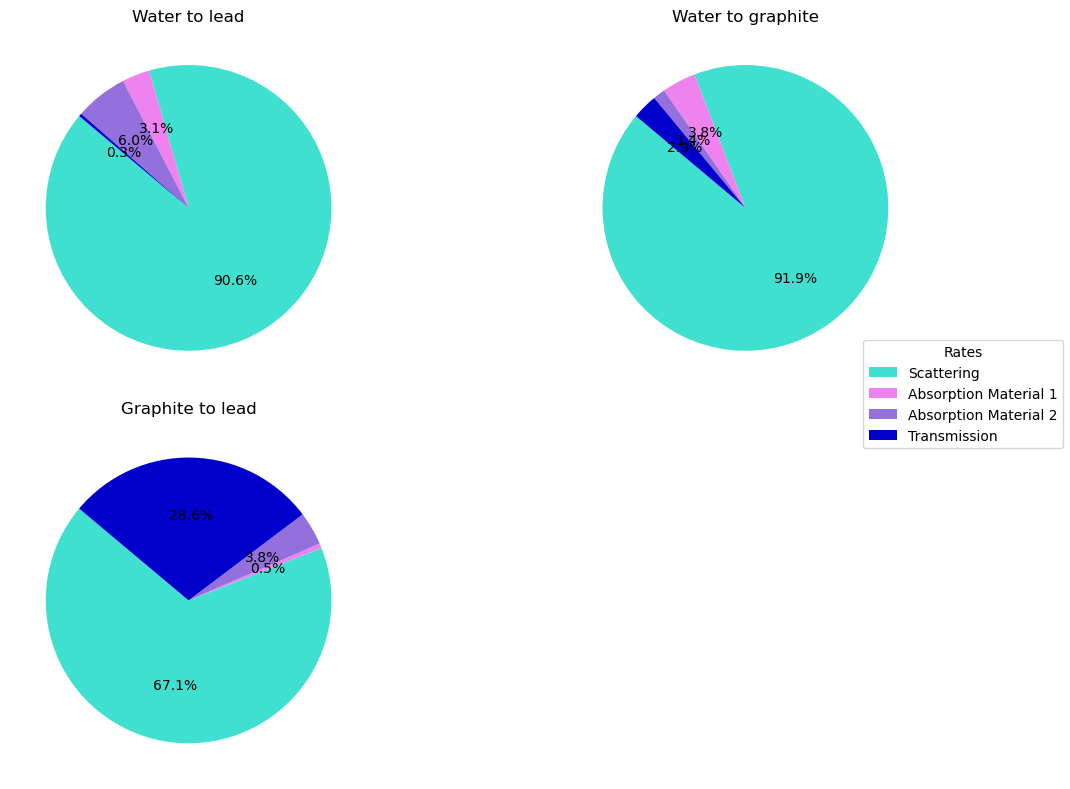

In [21]:
# Water to lead
water_lead_rates = material_rates(N, total_mfp_list[0], total_mfp_list[1], total_cross_section_list[0],
               total_cross_section_list[1], absorption_probability_list[0], absorption_probability_list[1],
               L, number_iterations)
print_results_woodcock('Water to lead', N,  L, number_iterations, water_lead_rates)

# Water to Graphite
water_graphite_rates = material_rates(N, total_mfp_list[0], total_mfp_list[2], total_cross_section_list[0],
               total_cross_section_list[2], absorption_probability_list[0], absorption_probability_list[2],
               L, number_iterations)
print_results_woodcock('Water to graphite', N,  L, number_iterations, water_graphite_rates)

# Graphite to Lead
graphite_lead_rates = material_rates(N, total_mfp_list[2], total_mfp_list[1], total_cross_section_list[2],
               total_cross_section_list[1], absorption_probability_list[2], absorption_probability_list[1],
               L, number_iterations)
print_results_woodcock('Graphite to lead', N,  L, number_iterations, graphite_lead_rates)

# Plotting
titles = ['Water to lead', 'Water to graphite', 'Graphite to lead']
plot_rates_pie(water_lead_rates, water_graphite_rates, graphite_lead_rates, titles)

From this it can be deduced that water to lead causes the least neutrons to transmit. This means that it would be the best neutron shielding material out of the results that are obtained from this simulation. The physical reasons behind why the materials differ in effectiveness was discussed at the end of the previous method.

In [22]:
notebook_runtime_end = timer.time()
notebook_runtime = notebook_runtime_end - notebook_runtime_start
print(notebook_runtime)

41.502182722091675
